In [1]:
#! python -m pip install ipympl geocube folium mapclassify -q
import numpy as np
import geopandas as gpd
import pandas as pd
from matplotlib import pyplot as plt
import os
import rioxarray as rio
import xarray as xr
import rasterio
import glob
from geocube.api.core import make_geocube
from shapely.errors import ShapelyDeprecationWarning
import warnings
import folium
from folium import plugins
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

In [2]:
# reference dict with the correct data product and its associated metadata for a given year
# some datasets are used for multiple years so you'll see some duplicate values
# lf_dict = { 
#           '2013':{'evt_path':'/projects/shared-buckets/gsfc_landslides/LANDFIRE/US_130_EVT/Tif/us_130evt.tif',
#                   'metadata_path':'/projects/shared-buckets/gsfc_landslides/LANDFIRE/US_130_EVT/CSV_Data/us_130evt.csv'},
#           '2014':{'evt_path':'/projects/shared-buckets/gsfc_landslides/LANDFIRE/US_130_EVT/Tif/us_130evt.tif',
#                   'metadata_path':'/projects/shared-buckets/gsfc_landslides/LANDFIRE/US_130_EVT/CSV_Data/us_130evt.csv'},
#           '2015':{'evt_path':'/projects/shared-buckets/gsfc_landslides/LANDFIRE/US_140_EVT/Tif/us_140evt.tif',
#                   'metadata_path':'/projects/shared-buckets/gsfc_landslides/LANDFIRE/US_140_EVT/CSV_Data/us_140evt.csv'},
#           '2016':{'evt_path':'/projects/shared-buckets/gsfc_landslides/LANDFIRE/US_140_EVT/Tif/us_140evt.tif',
#                   'metadata_path':'/projects/shared-buckets/gsfc_landslides/LANDFIRE/US_140_EVT/CSV_Data/us_140evt.csv'},
#           '2017':{'evt_path':'/projects/shared-buckets/gsfc_landslides/LANDFIRE/LF2016_EVT_200_CONUS/Tif/LC16_EVT_200.tif',
#                   'metadata_path':'/projects/shared-buckets/gsfc_landslides/LANDFIRE/LF2016_EVT_200_CONUS/CSV_Data/LF16_EVT_200.csv'},
#           '2018':{'evt_path':'/projects/shared-buckets/gsfc_landslides/LANDFIRE/LF2016_EVT_200_CONUS/Tif/LC16_EVT_200.tif',
#                   'metadata_path':'/projects/shared-buckets/gsfc_landslides/LANDFIRE/LF2016_EVT_200_CONUS/CSV_Data/LF16_EVT_200.csv'},
#           '2019':{'evt_path':'/projects/shared-buckets/gsfc_landslides/LANDFIRE/LF2016_EVT_200_CONUS/Tif/LC16_EVT_200.tif',
#                   'metadata_path':'/projects/shared-buckets/gsfc_landslides/LANDFIRE/LF2016_EVT_200_CONUS/CSV_Data/LF16_EVT_200.csv'},
#           '2020':{'evt_path':'/projects/shared-buckets/gsfc_landslides/LANDFIRE/LF2016_EVT_200_CONUS/Tif/LC16_EVT_200.tif',
#                   'metadata_path':'/projects/shared-buckets/gsfc_landslides/LANDFIRE/LF2016_EVT_200_CONUS/CSV_Data/LF16_EVT_200.csv'},
#           '2021':{'evt_path':'/projects/shared-buckets/gsfc_landslides/LANDFIRE/LF2016_EVT_200_CONUS/Tif/LC16_EVT_200.tif',
#                   'metadata_path':'/projects/shared-buckets/gsfc_landslides/LANDFIRE/LF2016_EVT_200_CONUS/CSV_Data/LF16_EVT_200.csv'}
# }

In [3]:
# read in all metadata files, find all the common cols across different years of data
# lf12_metadata = pd.read_csv('/projects/shared-buckets/gsfc_landslides/LANDFIRE/US_130_EVT/CSV_Data/us_130evt.csv')
# lf14_metadata = pd.read_csv('/projects/shared-buckets/gsfc_landslides/LANDFIRE/US_140_EVT/CSV_Data/us_140evt.csv')
# lf16_metadata = pd.read_csv('/projects/shared-buckets/gsfc_landslides/LANDFIRE/LF2016_EVT_200_CONUS/CSV_Data/LF16_EVT_200.csv')

# overlapping_cols = list(set(lf12_metadata.columns)&
#                         set(lf14_metadata.columns)&
#                         set(lf16_metadata.columns))
# overlapping_cols.remove('VALUE')
# print(overlapping_cols,'\n')

In [2]:
# 2015 Largefires for Western US
lf_files = glob.glob('/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/')
lf_ids = list(set([file.split('Largefire/')[1].split('_')[0] for file in lf_files])) # unique lf ids

In [402]:
#lf_ids
#lf_ids = lf_ids[0:10]
#print('Number of LF ids:',len(lf_ids))
lf_ids = lf_ids[0:10]


In [3]:
# each largefire id has a file for each timestep which has entire evolution up to that point.
# the latest one has the most up-to-date info for that fire
largefire_dict = dict.fromkeys(lf_ids)
for lf_id in lf_ids:
    most_recent_file = [file for file in lf_files if lf_id in file][-1]
    largefire_dict[lf_id] = most_recent_file

In [4]:
def load_large_fire(fireID, year = "2020", path_region = "WesternUS_REDO", layer = "perimeter"):
    '''
    loads in largefire file based on fireID and layer, then preps it for "explore" by adding centriod data. Currently limited to one year. 
    
    INPUTS:
        
        fireID (str): fireID offire of interest. Can be found in gdf files read in by prep_gdf and load_file. Can be selected interactivly form a gdf if use gdf.explore()
        year (str): Year that fires took place. Default to 2019. Availible options differ by path_region. 
        path_region (str): This constructs the path that the fires are stored in. WesternUS and CONUS availible. 
    '''
    lf_files = glob.glob('/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/' + path_region +'/'+ year +'/Largefire/F' + fireID + '_*') 
    lf_ids = list(set([file.split('Largefire/')[1].split('_')[0] for file in lf_files])) 
    largefire_dict = dict.fromkeys(lf_ids)
    
    for lf_id in lf_ids:
         most_recent_file = [file for file in lf_files if lf_id in file][-1]
         largefire_dict[lf_id] = most_recent_file
    
    gdf = pd.concat([gpd.read_file(file, layer = layer) for key, file in largefire_dict.items()], 
                   ignore_index=True)
    gdf = gdf.to_crs('EPSG:4326')
    gdf['fireID'] = fireID
    gdf['lon'] = gdf.centroid.x
    gdf['lat'] = gdf.centroid.y
    return gdf

# def load_lf(lf_id,file_path,layer='perimeters'):
#     '''Load in Largefire data, subset to CA only'''
#     gdf = gpd.read_file(file_path,layer=layer)
#     #print('lf current crs:',gdf.crs)
#     gdf['ID'] = lf_id
#     #gdf.to_crs('EPSG:6933',inplace=True)
#     #print('lf new crs:',gdf.crs)
#     #gdf = gdf.cx[xmin:xmax, ymin:ymax] # global variables from above for subsetting
    
#     return gdf

In [5]:
#del(lf_files)
frs = []
ids = ["10261", "13525", "12960", "12779"]#['13203', '12959', '13051'] ## Sample of oregon 2020 fires
for i in ids:
    tmp = load_large_fire(i)
    frs.append(tmp)
perimeters = pd.concat(frs)    

/tmp/ipykernel_11414/2887014536.py:23: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/tmp/ipykernel_11414/2887014536.py:24: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/tmp/ipykernel_11414/2887014536.py:23: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/tmp/ipykernel_11414/2887014536.py:24: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] =

In [6]:
pixs = []
for i in ids:
    tmp2 = load_large_fire(i, layer = "nfplist")
    pixs.append(tmp2)
pixels = pd.concat(pixs)

/tmp/ipykernel_11414/2887014536.py:23: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/tmp/ipykernel_11414/2887014536.py:24: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/tmp/ipykernel_11414/2887014536.py:23: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/tmp/ipykernel_11414/2887014536.py:24: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] =

In [58]:

#perimeters = pd.concat([load_lf(lf_id,file_path,layer='perimeter') for lf_id, file_path in largefire_dict.items()],ignore_index=True)
#pixels = pd.concat([load_lf(lf_id,file_path,layer='nfplist') for lf_id, file_path in largefire_dict.items()],ignore_index=True)

#perimeters.set_index('FireID',inplace=True)
#pixels.set_index('FireID',inplace=True)
#pixels.to_crs('ESRI:102039',inplace=True)

In [7]:
perimeters.to_crs('epsg:4326',inplace=True)
pixels.to_crs('epsg:4326',inplace=True)

In [408]:
# mtbs_perimeters = gpd.read_file('/projects/shared-buckets/gsfc_landslides/mtbs/mtbs_perims_DD.shp')
# mtbs_perimeters.to_crs('ESRI:102039',inplace=True)
# mtbs_perimeters['Ig_Date'] = pd.to_datetime(mtbs_perimeters['Ig_Date'])

In [8]:
yr = '2020' #fires_path.split('.gpkg')[0][-4:] # ugly 1 line yr parse

In [9]:
start = pd.to_datetime(yr+'-01-01')
end = pd.to_datetime(yr+'-12-31')

In [10]:
xmin, ymin, xmax, ymax = perimeters.total_bounds

In [63]:
# mtbs_subset = mtbs_perimeters[(mtbs_perimeters['Ig_Date']>start)&
#                              (mtbs_perimeters['Ig_Date']<end)]
# mtbs_subset = mtbs_subset.cx[xmin:xmax,ymin:ymax]
# print(mtbs_subset.shape)

In [15]:
#p = perimeters.sort_values(['ID','t'])

In [16]:
#p = p.loc[p['ID'].drop_duplicates(keep='last').index]

In [17]:
#p.shape

In [18]:
# m = mtbs_subset.geometry.explore(color='blue',name='MTBS')
# p.geometry.explore(m=m,color='black',name='Largefire')
# folium.LayerControl().add_to(m)
# m

In [19]:
# mtbs_paths = glob.glob("/projects/shared-buckets/gsfc_landslides/mtbs/*.tif")
# #_ = [print(path) for path in mtbs_paths]

In [225]:
# # load in mtbs data for that year - this is a single band, CONUS scale raster
# mtbs_path = [path for path in mtbs_paths if yr in path][0]
# mtbs = rio.open_rasterio(mtbs_path,variable='band')
# mtbs = mtbs.squeeze().drop('band')
    
# # load in evt data & metadata, using the dict from earlier
# evt = rio.open_rasterio(lf_dict[yr]['evt_path']) 
# evt_metadata = pd.read_csv(lf_dict[yr]['metadata_path'],index_col='VALUE')
# evt_metadata.drop(-9999,inplace=True) # -9999 is the nodata value
#fire.columns

In [412]:
def format_pixel_dates(row):
    date = row.datetime.split('T')[0]
    period = row.ampm
    if period=='AM':
        date = date+'T00:00:00'
    else:
        date = date+'T12:00:00'
    
    return date

def perimeter_union(fire):
    times = fire.index.unique()
    #print(times)
    fire['t'] = fire.index
    poly_list = []
    for i in range(len(times)-1): # -1 because we're looking 1 timestep ahead at each time t
        j = i + 1
        
        if i==0: # make sure to include first observation
            base_perimeter = fire.loc[times[i]:times[i]][['t','geometry']].copy()
            poly_list.append(base_perimeter)
        
        f1 = fire.loc[times[i]:times[i]] # times[i]:times[i] returns dataframe (we want that)
        f2 = fire.loc[times[j]:times[j]] # next timestep
        diff = f2.overlay(f1, how='difference') # take difference
        
        ex = diff.explode(ignore_index=True) # convert single multipolygon geo to many polygons
        ex_polys = ex[['t','geometry', 'meanFRP']].copy() # only need these cols
        poly_list.append(ex_polys)
    return pd.concat(poly_list) #,ignore_index=True 

def add_ampm(row):
    hr = row['t'].split('T')[1]
    if hr=='00:00:00':
        row['isPM'] = 0
    else:
        row['isPM'] = 1
    return row

In [11]:
#m = perimeters.explore(column='meanFRP',tiles='Stamen Terrain',
#             style_kwds={'fillOpacity':0})
#mtbs_subset.drop('Ig_Date',axis=1).explore(m=m)
#folium.LayerControl().add_to(m)
#m

In [413]:
perimeters["ID"] = perimeters.fireID
pixels["ID"] = pixels.fireID
perimeters.columns

Index(['n_pixels', 'n_newpixels', 'farea', 'fperim', 'flinelen', 'duration',
       'pixden', 'meanFRP', 't', 'geometry', 'fireID', 'lon', 'lat', 'ID'],
      dtype='object')

In [414]:
max_areas = perimeters.groupby('ID')['farea'].max().sort_values(ascending=False)
print(max_areas.index[1]) # F9625

10261


In [3]:
i = 0
# KNP_Complex, WINDY
#ID = max_areas.index[i]
ID = 'F9625'
fire = perimeters[perimeters['ID']==ID].copy()
fire.sort_values('t',ascending=True,inplace=True)
fire.t = fire.t.astype("datetime64[ns]")
fire_pix  = pixels[pixels['ID']==ID].copy()
fire['fid'] = fire.index

NameError: name 'perimeters' is not defined

In [70]:
#fire.set_index('t',inplace=True)
#fire_pix.set_index('t',inplace=True)
#fire = fire.sort_index()

In [416]:
times = fire.index.unique()
#print(times)
#fire['t'] = fire.index
poly_list = []
for i in range(len(times)-1): # -1 because we're looking 1 timestep ahead at each time t
    j = i + 1

    if i==0: # make sure to include first observation
        base_perimeter = fire.loc[times[i]:times[i]][['t','geometry']].copy()
        poly_list.append(base_perimeter)

    f1 = fire.loc[times[i]:times[i]] # times[i]:times[i] returns dataframe (we want that)
    f2 = fire.loc[times[j]:times[j]] # next timestep
    diff = f2.overlay(f1, how='difference') # take difference

    ex = diff.explode(ignore_index=True) # convert single multipolygon geo to many polygons
    ex_polys = ex[['t','geometry', 'meanFRP', "duration", "pixden", "flinelen", "fperim", "farea", "n_newpixels", "n_pixels"]].copy() # only need these cols
    poly_list.append(ex_polys)
union = pd.concat(poly_list)

In [417]:
union

,t,geometry,meanFRP,duration,pixden,flinelen,fperim,farea,n_newpixels,n_pixels
58,2020-09-14 12:00:00,"MULTIPOLYGON (((-122.84220 41.21380, -122.8421...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,2020-09-15 00:00:00,"POLYGON ((-122.85148 41.21235, -122.85354 41.2...",4.798333,0.5,8.192526,3.782624,3.782624,0.976500,6.0,8.0
1,2020-09-15 00:00:00,"POLYGON ((-122.85109 41.21194, -122.85114 41.2...",4.798333,0.5,8.192526,3.782624,3.782624,0.976500,6.0,8.0
2,2020-09-15 00:00:00,"POLYGON ((-122.85124 41.21207, -122.85129 41.2...",4.798333,0.5,8.192526,3.782624,3.782624,0.976500,6.0,8.0
3,2020-09-15 00:00:00,"POLYGON ((-122.85137 41.21221, -122.85141 41.2...",4.798333,0.5,8.192526,3.782624,3.782624,0.976500,6.0,8.0
...,...,...,...,...,...,...,...,...,...,...
3,2020-09-22 12:00:00,"POLYGON ((-122.87131 41.25822, -122.87131 41.2...",7.375000,8.0,19.510543,2.389387,15.335584,13.121111,4.0,256.0
4,2020-09-22 12:00:00,"POLYGON ((-122.87123 41.25838, -122.87122 41.2...",7.375000,8.0,19.510543,2.389387,15.335584,13.121111,4.0,256.0
5,2020-09-22 12:00:00,"POLYGON ((-122.87113 41.25853, -122.87112 41.2...",7.375000,8.0,19.510543,2.389387,15.335584,13.121111,4.0,256.0
6,2020-09-22 12:00:00,"POLYGON ((-122.87101 41.25868, -122.87100 41.2...",7.375000,8.0,19.510543,2.389387,15.335584,13.121111,4.0,256.0


In [418]:
fire_pix

,x,y,frp,DS,DT,ampm,datetime,sat,t,geometry,fireID,lon,lat,ID
0,-1.886139e+06,-156785.395229,2.54,0.366650,0.396923,AM,2020-09-15 10:12:00,SNPP,2020-09-15 00:00:00,POINT (-122.84325 41.21131),13525,-122.843246,41.211310,13525
1,-1.886169e+06,-156540.454003,4.86,0.599427,0.398156,PM,2020-09-14 21:54:00,SNPP,2020-09-14 12:00:00,POINT (-122.84438 41.21334),13525,-122.844375,41.213336,13525
2,-1.886167e+06,-156485.818348,5.00,0.378697,0.425336,AM,2020-09-16 09:54:00,SNPP,2020-09-16 00:00:00,POINT (-122.84453 41.21381),13525,-122.844528,41.213809,13525
3,-1.886067e+06,-156609.884491,0.73,0.465454,0.444624,AM,2020-09-17 09:36:00,SNPP,2020-09-17 00:00:00,POINT (-122.84297 41.21299),13525,-122.842971,41.212993,13525
4,-1.886185e+06,-156263.531616,7.25,0.468490,0.451106,PM,2020-09-15 21:36:00,SNPP,2020-09-15 12:00:00,POINT (-122.84544 41.21567),13525,-122.845443,41.215671,13525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,-1.886581e+06,-156448.201396,4.86,0.599280,0.397921,PM,2020-09-14 21:54:00,SNPP,2020-09-14 12:00:00,POINT (-122.84945 41.21311),13525,-122.849449,41.213107,13525
254,-1.886548e+06,-156299.803490,5.00,0.378757,0.425480,AM,2020-09-16 09:54:00,SNPP,2020-09-16 00:00:00,POINT (-122.84954 41.21446),13525,-122.849540,41.214461,13525
255,-1.886666e+06,-156181.179947,5.34,0.468356,0.450820,PM,2020-09-15 21:36:00,SNPP,2020-09-15 12:00:00,POINT (-122.85129 41.21519),13525,-122.851287,41.215186,13525
256,-1.886709e+06,-156195.274517,8.72,0.379916,0.428274,PM,2020-09-16 21:18:00,SNPP,2020-09-16 12:00:00,POINT (-122.85173 41.21496),13525,-122.851730,41.214961,13525


In [419]:
union['id'] = union.index
union.sort_values('t',ascending=False,inplace=True)

In [420]:
#fire_pix['geometry'] = fire_pix.geometry.buffer(0.02)
#join_p = union.sjoin(fire_pix)
#join_p['pixel_interval'] = pd.to_datetime(join_p['index_right'])
    
#frp summary stats
#grp = join_p.groupby(join_p['id']).agg(['max','median','mean','count'])['frp']

# num of unique pixel intervals observed (e.g., [2021-01-01 AM, 2021-01-01 PM] = 2)
#grp_nunique = join_p.groupby(join_p['id'])['pixel_interval'].nunique()

# total time between first and last observation for that region
#grp_range = join_p.groupby(join_p['id'])['pixel_interval'].agg(['min','max'])
#grp_range['range'] = grp_range['max'] - grp_range['min']

#add these values to the other groupby op
#grp['unique_periods'] = grp_nunique

# for col in grp_range.columns:
    
#     if col=='range':
#         grp['date_'+col] = grp_range['range'] # timedelta object
#         continue
    
#     # convert dates back to string
#     grp['date_'+col] = grp_range[col].apply(lambda x: x.strftime('%Y-%m-%dT%H:%M:%S'))

# result = pd.merge(union, grp, left_on='id',right_index=True,how='outer')
# result.rename(columns={'max':'frp_max',
#                        'median':'frp_median',
#                        'mean':'frp_mean',
#                        'count':'pixel_count'},inplace=True)
result = union
result.t = result.t.astype("str")
result.dropna(inplace=True)
#result = result.apply(add_ampm,axis=1) # add PM flag # Tess Change
result['fid'] = fire['fid'].unique()[0]
#result['Name'] = fire['Name'].unique()[0]
#result['date_range_h'] = result['date_range']/ np.timedelta64(1, 'h')
#result['area'] = result.geometry.area / 1000000

In [421]:
union

,t,geometry,meanFRP,duration,pixden,flinelen,fperim,farea,n_newpixels,n_pixels,id,fid
7,2020-09-22 12:00:00,"POLYGON ((-122.87087 41.25881, -122.87086 41.2...",7.375000,8.0,19.510543,2.389387,15.335584,13.121111,4.0,256.0,7,58
6,2020-09-22 12:00:00,"POLYGON ((-122.87101 41.25868, -122.87100 41.2...",7.375000,8.0,19.510543,2.389387,15.335584,13.121111,4.0,256.0,6,58
5,2020-09-22 12:00:00,"POLYGON ((-122.87113 41.25853, -122.87112 41.2...",7.375000,8.0,19.510543,2.389387,15.335584,13.121111,4.0,256.0,5,58
4,2020-09-22 12:00:00,"POLYGON ((-122.87123 41.25838, -122.87122 41.2...",7.375000,8.0,19.510543,2.389387,15.335584,13.121111,4.0,256.0,4,58
3,2020-09-22 12:00:00,"POLYGON ((-122.87131 41.25822, -122.87131 41.2...",7.375000,8.0,19.510543,2.389387,15.335584,13.121111,4.0,256.0,3,58
...,...,...,...,...,...,...,...,...,...,...,...,...
19,2020-09-15 12:00:00,"POLYGON ((-122.85122 41.21205, -122.85122 41.2...",9.807273,1.0,10.512212,4.965416,5.625778,1.807422,11.0,19.0,19,58
2,2020-09-15 00:00:00,"POLYGON ((-122.85124 41.21207, -122.85129 41.2...",4.798333,0.5,8.192526,3.782624,3.782624,0.976500,6.0,8.0,2,58
1,2020-09-15 00:00:00,"POLYGON ((-122.85109 41.21194, -122.85114 41.2...",4.798333,0.5,8.192526,3.782624,3.782624,0.976500,6.0,8.0,1,58
0,2020-09-15 00:00:00,"POLYGON ((-122.85148 41.21235, -122.85354 41.2...",4.798333,0.5,8.192526,3.782624,3.782624,0.976500,6.0,8.0,0,58


<AxesSubplot: >

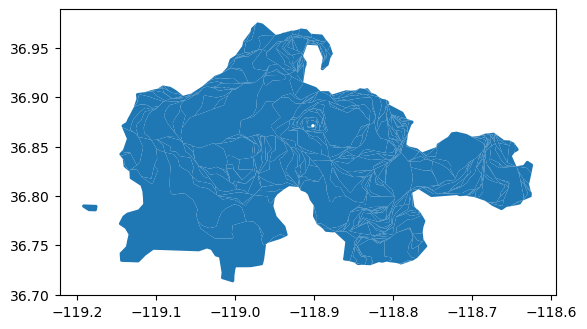

In [423]:
# print(len(result['id'].unique()) == len(result['id']) == len(result['geometry'].unique()))
# m = result.dropna().explore(column='frp_mean',
#                                              cmap='YlOrRd',
#                                         tiles='Stamen Terrain',
#                                         style_kwds={'fillOpacity':0.1})
# #fire_pix.explore(m=m,vmax=300,column='frp',cmap='YlOrRd')
# folium.LayerControl().add_to(m)
# m

In [424]:
# i = 1
# times = result['t'].unique()
# times.sort()
# m = result[(result['t']==times[i])|(result['t']==times[i+1])].drop('date_range',axis=1).explore(column='frp_mean',
#              bounds                          tiles='Stamen Terrain',
#                                         style_kwds={'fillOpacity':0.1})
# #fire_pix.explore(m=m,vmax=300,column='frp',cmap='YlOrRd')
# folium.LayerControl().add_to(m)
# m
perim = max(fire[fire.t == max(fire.t)].geometry)

In [425]:
lons = perim.envelope.exterior.coords.xy[0]
lats = perim.envelope.exterior.coords.xy[1]

print(lons, lats)

array('d', [-122.8719070299661, -122.83687928423275, -122.83687928423275, -122.8719070299661, -122.8719070299661]) array('d', [41.20865655893494, 41.20865655893494, 41.26298198546766, 41.26298198546766, 41.20865655893494])


In [426]:
bounds = fire.geometry.total_bounds # final perimeter geo
fire = fire.to_crs("epsg:4326")
minx = bounds[0]
miny = bounds[1]
maxx = bounds[2]
maxy = bounds[3]
print(bounds)


[-122.87190703   41.20865656 -122.83687928   41.26298199]


In [2]:
# Get FWI raster instead of the MBTS data

imerge = xr.open_dataset("s3://veda-data-store-staging/EIS/zarr/FWI-GEOS-5-Hourly", engine="zarr", chunks = "auto") #, chunks = "auto"
imerge.rio.write_crs("epsg:4326", inplace=True)
imerge.rio.set_spatial_dims(x_dim = "lon", y_dim = "lat", inplace = True)
#imerge_year = imerge['GPM.LATE.v5_FWI'].loc["2020-01-01":"2020-10-31"]
imerge

tmp = imerge.rio.clip_box(minx = min(lons), miny = min(lats), maxx=max(lons), maxy = max(lats), auto_expand= True)

#tmp = tmp["GEOS-5_FWI"]
# bs = mtbs.sel(x=slice(minx,maxx),
#               y=slice(maxy,miny))
# bs_mask = (bs < 5) & (bs != 0)
# bs = bs.where(bs_mask)

NameError: name 'lons' is not defined

In [428]:
#tmp= tmp.rename({"lat":"y", "lon":"x"})
#tmp = bs["GEOS-5_FWI"]
tmp = tmp.rio.set_spatial_dims(x_dim = "lon", y_dim = "lat")
#type(tmp)

In [429]:
#plt.scatter(bs["GEOS-5_FWI"])
#imerge
#g = result.iloc[2].geometry.__geo_interface__
import rioxarray as rio
import rasterio

#tmp.rio.bounds()
tmp['GEOS-5_FWI']

<xarray.DataArray 'GEOS-5_FWI' (time: 26880, lat: 3, lon: 2)>
dask.array<getitem, shape=(26880, 3, 2), dtype=float32, chunksize=(360, 3, 2), chunktype=numpy.ndarray>
Coordinates:
  * lat          (lat) float64 41.0 41.25 41.5
  * lon          (lon) float64 -123.1 -122.8
  * time         (time) datetime64[ns] 2020-01-01 ... 2023-01-24T23:00:00
    spatial_ref  int64 0
Attributes:
    long_name:   GEOS-5 hourly Fire Weather index, local time
    short_name:  GEOS-5_FWI
    units:

In [430]:
#bs.rio.clip(g)
tmp["GEOS-5_FWI"]

<xarray.DataArray 'GEOS-5_FWI' (time: 26880, lat: 3, lon: 2)>
dask.array<getitem, shape=(26880, 3, 2), dtype=float32, chunksize=(360, 3, 2), chunktype=numpy.ndarray>
Coordinates:
  * lat          (lat) float64 41.0 41.25 41.5
  * lon          (lon) float64 -123.1 -122.8
  * time         (time) datetime64[ns] 2020-01-01 ... 2023-01-24T23:00:00
    spatial_ref  int64 0
Attributes:
    long_name:   GEOS-5 hourly Fire Weather index, local time
    short_name:  GEOS-5_FWI
    units:

In [431]:
# lf_subset = evt.sel(x=slice(minx,maxx),
#                     y=slice(maxy,miny)).squeeze()

# lf_subset_matched = lf_subset.rio.reproject_match(bs,resampling=1).where(bs_mask)
# lf_subset_matched.assign_coords({"x": bs.x,
#                                  "y": bs.y})

# bs_f = bs.values.flatten()
# lf_f = lf_subset_matched.values.flatten()

#result.t = result.t.astype("datetime64[ns]")
#result.t = result.t.astype("datetime64[ns]")
result

,t,geometry,meanFRP,duration,pixden,flinelen,fperim,farea,n_newpixels,n_pixels,id,fid
7,2020-09-22 12:00:00,"POLYGON ((-122.87087 41.25881, -122.87086 41.2...",7.375000,8.0,19.510543,2.389387,15.335584,13.121111,4.0,256.0,7,58
6,2020-09-22 12:00:00,"POLYGON ((-122.87101 41.25868, -122.87100 41.2...",7.375000,8.0,19.510543,2.389387,15.335584,13.121111,4.0,256.0,6,58
5,2020-09-22 12:00:00,"POLYGON ((-122.87113 41.25853, -122.87112 41.2...",7.375000,8.0,19.510543,2.389387,15.335584,13.121111,4.0,256.0,5,58
4,2020-09-22 12:00:00,"POLYGON ((-122.87123 41.25838, -122.87122 41.2...",7.375000,8.0,19.510543,2.389387,15.335584,13.121111,4.0,256.0,4,58
3,2020-09-22 12:00:00,"POLYGON ((-122.87131 41.25822, -122.87131 41.2...",7.375000,8.0,19.510543,2.389387,15.335584,13.121111,4.0,256.0,3,58
...,...,...,...,...,...,...,...,...,...,...,...,...
19,2020-09-15 12:00:00,"POLYGON ((-122.85122 41.21205, -122.85122 41.2...",9.807273,1.0,10.512212,4.965416,5.625778,1.807422,11.0,19.0,19,58
2,2020-09-15 00:00:00,"POLYGON ((-122.85124 41.21207, -122.85129 41.2...",4.798333,0.5,8.192526,3.782624,3.782624,0.976500,6.0,8.0,2,58
1,2020-09-15 00:00:00,"POLYGON ((-122.85109 41.21194, -122.85114 41.2...",4.798333,0.5,8.192526,3.782624,3.782624,0.976500,6.0,8.0,1,58
0,2020-09-15 00:00:00,"POLYGON ((-122.85148 41.21235, -122.85354 41.2...",4.798333,0.5,8.192526,3.782624,3.782624,0.976500,6.0,8.0,0,58


In [432]:
result.t = result.t.astype("datetime64[ns]")
result.meanFRP = result.meanFRP.astype("float")
#result["numeric_t"] = result.index

result

,t,geometry,meanFRP,duration,pixden,flinelen,fperim,farea,n_newpixels,n_pixels,id,fid
7,2020-09-22 12:00:00,"POLYGON ((-122.87087 41.25881, -122.87086 41.2...",7.375000,8.0,19.510543,2.389387,15.335584,13.121111,4.0,256.0,7,58
6,2020-09-22 12:00:00,"POLYGON ((-122.87101 41.25868, -122.87100 41.2...",7.375000,8.0,19.510543,2.389387,15.335584,13.121111,4.0,256.0,6,58
5,2020-09-22 12:00:00,"POLYGON ((-122.87113 41.25853, -122.87112 41.2...",7.375000,8.0,19.510543,2.389387,15.335584,13.121111,4.0,256.0,5,58
4,2020-09-22 12:00:00,"POLYGON ((-122.87123 41.25838, -122.87122 41.2...",7.375000,8.0,19.510543,2.389387,15.335584,13.121111,4.0,256.0,4,58
3,2020-09-22 12:00:00,"POLYGON ((-122.87131 41.25822, -122.87131 41.2...",7.375000,8.0,19.510543,2.389387,15.335584,13.121111,4.0,256.0,3,58
...,...,...,...,...,...,...,...,...,...,...,...,...
19,2020-09-15 12:00:00,"POLYGON ((-122.85122 41.21205, -122.85122 41.2...",9.807273,1.0,10.512212,4.965416,5.625778,1.807422,11.0,19.0,19,58
2,2020-09-15 00:00:00,"POLYGON ((-122.85124 41.21207, -122.85129 41.2...",4.798333,0.5,8.192526,3.782624,3.782624,0.976500,6.0,8.0,2,58
1,2020-09-15 00:00:00,"POLYGON ((-122.85109 41.21194, -122.85114 41.2...",4.798333,0.5,8.192526,3.782624,3.782624,0.976500,6.0,8.0,1,58
0,2020-09-15 00:00:00,"POLYGON ((-122.85148 41.21235, -122.85354 41.2...",4.798333,0.5,8.192526,3.782624,3.782624,0.976500,6.0,8.0,0,58


In [433]:
tmp["GEOS-5_FWI"].lon.min()

<xarray.DataArray 'lon' ()>
array(-123.125)
Coordinates:
    spatial_ref  int64 0

In [434]:
#result.t = result.t.astype("datetime64[ns]")
result = result.rename(columns={"t":"time"})
result_tmp = result[["geometry",'meanFRP', 'time']]

tmp['GEOS-5_FWI'] = tmp['GEOS-5_FWI'].rio.set_spatial_dims(x_dim = "lon", y_dim = "lat")

cube = make_geocube(vector_data=result_tmp, 
                    measurements = ['meanFRP', 'time'], #'duration', 'pixden', 'flinelen', 'fperim','farea', 'n_newpixels', 'n_pixels']
                    datetime_measurements = ['time'],
                    like = tmp['GEOS-5_FWI'], 
                    fill=0) #like = tmp,,


cube
#?make_geocube

<xarray.Dataset>
Dimensions:      (y: 3, x: 2)
Coordinates:
  * y            (y) float64 41.0 41.25 41.5
  * x            (x) float64 -123.1 -122.8
    spatial_ref  int64 0
Data variables:
    meanFRP      (y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0
    time         (y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0

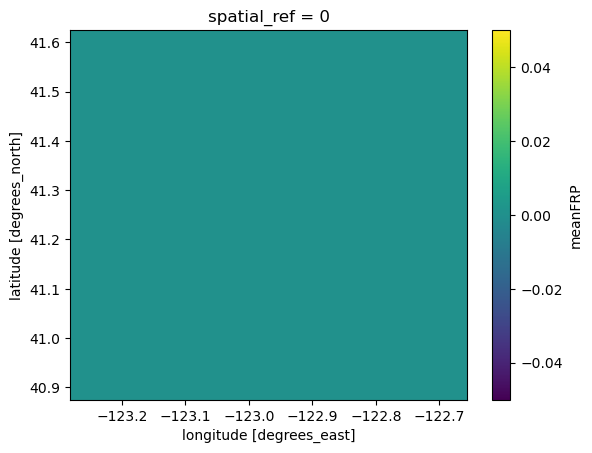

In [435]:
cube['meanFRP'].plot()

In [436]:

cube_df = cube.to_dataframe()
cube_df.reset_index(inplace=True)

In [437]:
cube_df

,y,x,meanFRP,time,spatial_ref
0,41.00,-123.1250,0.0,0.0,0
1,41.00,-122.8125,0.0,0.0,0
2,41.25,-123.1250,0.0,0.0,0
3,41.25,-122.8125,0.0,0.0,0
4,41.50,-123.1250,0.0,0.0,0
5,41.50,-122.8125,0.0,0.0,0


In [438]:
?make_geocube

Signature:
make_geocube(
    vector_data: Union[str, os.PathLike, geopandas.geodataframe.GeoDataFrame],
    measurements: Union[List[str], NoneType] = None,
    datetime_measurements: Union[List[str], NoneType] = None,
    output_crs: Any = None,
    resolution: Union[float, Iterable[float], NoneType] = None,
    align: Union[Tuple[float, float], NoneType] = None,
    geom: Union[str, Dict, shapely.geometry.base.BaseGeometry, odc.geo.geom.Geometry, NoneType] = None,
    like: Union[xarray.core.dataset.Dataset, xarray.core.dataarray.DataArray, NoneType] = None,
    fill: float = nan,
    group_by: Union[str, NoneType] = None,
    interpolate_na_method: Union[Literal['linear', 'nearest', 'cubic'], NoneType] = None,
    categorical_enums: Union[Dict[str, List], NoneType] = None,
    rasterize_function: Union[Callable[..., Union[numpy.ndarray[Any, numpy.dtype[+ScalarType]], NoneType]], NoneType] = None,
) -> xarray.core.dataset.Dataset
Docstring:
Rasterize vector data into an ``xarray`` ob

In [439]:
print(fire_pix.columns)
fire_pix.t = fire_pix.t.astype("datetime64[ns]")


Index(['x', 'y', 'frp', 'DS', 'DT', 'ampm', 'datetime', 'sat', 't', 'geometry',
       'fireID', 'lon', 'lat', 'ID'],
      dtype='object')


In [440]:
from geocube.rasterize import rasterize_points_griddata, rasterize_points_radial

tmp['GEOS-5_FWI'] = tmp['GEOS-5_FWI'].rio.set_spatial_dims(x_dim = "lon", y_dim = "lat")

cube = make_geocube(vector_data=fire_pix, 
                    measurements = ['frp', 't'], #'duration', 'pixden', 'flinelen', 'fperim','farea', 'n_newpixels', 'n_pixels']
                    datetime_measurements = ['t'],
                    like = tmp['GEOS-5_FWI'], 
                    group_by="t",
                    rasterize_function=rasterize_points_griddata,
                    fill=0) #like = tmp,,


cube

<xarray.Dataset>
Dimensions:      (t: 17, y: 3, x: 2)
Coordinates:
  * y            (y) float64 41.0 41.25 41.5
  * x            (x) float64 -123.1 -122.8
  * t            (t) datetime64[ns] 2020-09-14T12:00:00 ... 2020-09-23T12:00:00
    spatial_ref  int64 0
Data variables:
    frp          (t, y, x) float64 4.86 4.86 4.86 4.86 ... 6.48 6.48 6.48 6.48

In [441]:
imrg = tmp
type(imrg)
type(cube)
#cube = cube.set_coords(["y", "x", "t"])

cube = cube.swap_dims({'y':'lat', 
                        'x':'lon',
                        't':'time'})

cube = cube.rename({'y':'lat', 
                        'x':'lon',
                        't':'time'})
# cube = cube.set_index({'lat':'y', 
#                         'lon':'x',
#                         'time':'t'})
# cube = cube.set_index({'lat':'y', 
#                         'lon':'x',
#                         'time':'t'})

#?cube.set_coords

/tmp/ipykernel_496/1527468959.py:10: UserWarning: rename 'y' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  cube = cube.rename({'y':'lat',
/tmp/ipykernel_496/1527468959.py:10: UserWarning: rename 'x' to 'lon' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  cube = cube.rename({'y':'lat',
/tmp/ipykernel_496/1527468959.py:10: UserWarning: rename 't' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  cube = cube.rename({'y':'lat',


In [442]:
?cube.set_index

Signature:
cube.set_index(
    indexes: 'Mapping[Any, Hashable | Sequence[Hashable]] | None' = None,
    append: 'bool' = False,
    **indexes_kwargs: 'Hashable | Sequence[Hashable]',
) -> 'Dataset'
Docstring:
Set Dataset (multi-)indexes using one or more existing coordinates
or variables.

This legacy method is limited to pandas (multi-)indexes and
1-dimensional "dimension" coordinates. See
:py:meth:`~Dataset.set_xindex` for setting a pandas or a custom
Xarray-compatible index from one or more arbitrary coordinates.

Parameters
----------
indexes : {dim: index, ...}
    Mapping from names matching dimensions and values given
    by (lists of) the names of existing coordinates or variables to set
    as new (multi-)index.
append : bool, default: False
    If True, append the supplied index(es) to the existing index(es).
    Otherwise replace the existing index(es) (default).
**indexes_kwargs : optional
    The keyword arguments form of ``indexes``.
    One of indexes or indexes_kwargs 

In [443]:
cube

<xarray.Dataset>
Dimensions:      (time: 17, lat: 3, lon: 2)
Coordinates:
    lat          (lat) float64 41.0 41.25 41.5
    lon          (lon) float64 -123.1 -122.8
    time         (time) datetime64[ns] 2020-09-14T12:00:00 ... 2020-09-23T12:...
    spatial_ref  int64 0
Data variables:
    frp          (time, lat, lon) float64 4.86 4.86 4.86 4.86 ... 6.48 6.48 6.48

In [328]:
?cube.coords

Type:        property
String form: <property object at 0x7f64e4734630>
Docstring:  
Dictionary of xarray.DataArray objects corresponding to coordinate
variables


In [444]:
imrg = tmp

In [322]:
?imrg.assign

Signature:
imrg.assign(
    variables: 'Mapping[Any, Any] | None' = None,
    **variables_kwargs: 'Any',
) -> 'T_Dataset'
Docstring:
Assign new data variables to a Dataset, returning a new object
with all the original variables in addition to the new ones.

Parameters
----------
variables : mapping of hashable to Any
    Mapping from variables names to the new values. If the new values
    are callable, they are computed on the Dataset and assigned to new
    data variables. If the values are not callable, (e.g. a DataArray,
    scalar, or array), they are simply assigned.
**variables_kwargs
    The keyword arguments form of ``variables``.
    One of variables or variables_kwargs must be provided.

Returns
-------
ds : Dataset
    A new Dataset with the new variables in addition to all the
    existing variables.

Notes
-----
Since ``kwargs`` is a dictionary, the order of your arguments may not
be preserved, and so the order of the new variables is not well
defined. Assigning multiple 

In [371]:
cube.time.max()

<xarray.DataArray 'time' ()>
array('2020-09-23T12:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    spatial_ref  int64 0

In [452]:
imrg = imrg.sel(time = slice('2020-09-14T12:00:00.000000000', '2020-09-23T12:00:00.000000000'))

#merge = xr.merge([cube, imrg], join='outer', combine_attrs = "override", fill_value = 0)

#combo = cube.combine_first(imrg)


fwi = imrg['GEOS-5_FWI'][imrg['GEOS-5_FWI'].time.isin(cube.time)]

In [456]:
fwi
mr = xr.merge([cube, fwi], join='outer', combine_attrs = "override", fill_value = 0)
mr["GEOS-5_FWI"]
#type(merge)

In [457]:
mr.to_dataframe()

In [546]:
import eofs
import iris
from eofs.xarray import Eof
#from eofs.iris import Eof
from eofs.multivariate.standard import MultivariateEof

### Need to translate frp and FWI into anomolies before doing an EOF


mean = mr['GEOS-5_FWI'].mean(dim = 'time')
mr = mr.assign(FWI_mean = mr['GEOS-5_FWI'] - mean)
#mr

mean = mr['frp'].mean(dim = 'time')
mr = mr.assign(frp_mean = mr['frp'] - mean)
#mr

In [511]:
## Just FRP EOF

## Maybe taking out the meas was wrong? I think the function does it automatically. 
#frp = mr.frp_mean
frp = mr['GEOS-5_FWI']
solver = Eof(frp)

eofs = solver.eofs(neofs=1)
pc1 = solver.pcs(npcs=1, pcscaling=1)

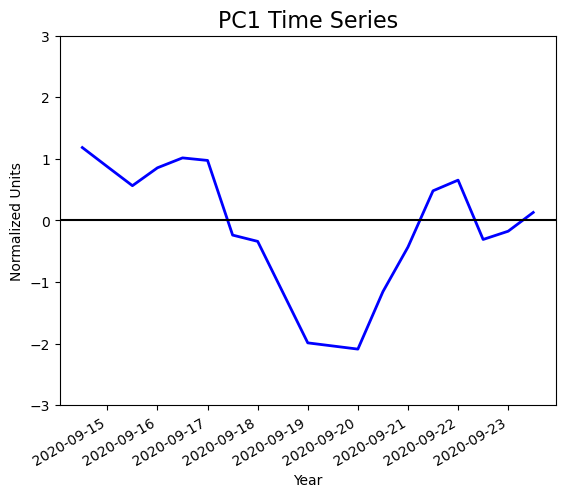

In [512]:
#eofs.plot()

plt.figure()
pc1[:, 0].plot(color='b', linewidth=2)
ax = plt.gca()
ax.axhline(0, color='k')
ax.set_ylim(-3, 3)
ax.set_xlabel('Year')
ax.set_ylabel('Normalized Units')
ax.set_title('PC1 Time Series', fontsize=16)

plt.show()

In [488]:
mr['frp'].time.max()

<xarray.DataArray 'time' ()>
array('2020-09-23T12:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    spatial_ref  int64 0

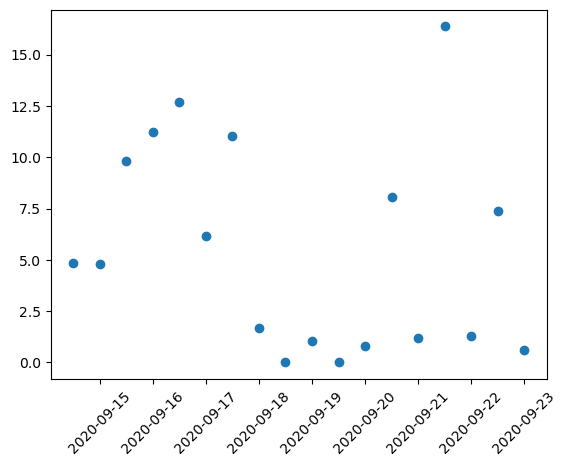

In [513]:
#perimeters = perimeters.sort_values(by = ["t"])

#plt.scatter(perimeters.t, perimeters.farea)
fire = fire[(fire.t < '2020-09-23T12:00:00.000000000')]
plt.scatter(fire.t, fire.meanFRP)
plt.xticks(rotation = 45)
plt.show()
#perimeters.fireID.unique()

None


In [550]:
## put into numpy for multivariate stuff


## Wait, maybe taking out the mean was wrong. 
fwi_cube = mr['FWI_mean'].to_numpy()
frp_cube = mr['frp_mean'].to_numpy()
fwi_cube

array([[[ 1.2217596e+01,  9.3126278e+00],
        [ 1.2344200e+01,  1.2692438e+01],
        [ 1.1335491e+01,  1.2408691e+01]],

       [[ 7.4614925e+00,  5.3878498e+00],
        [ 1.1359203e+01,  6.2540493e+00],
        [ 1.1548519e+01,  9.3741493e+00]],

       [[ 6.5716534e+00,  2.9945374e-04],
        [ 7.4873829e+00,  4.1658459e+00],
        [ 6.4525661e+00,  8.0191345e+00]],

       [[ 8.7265568e+00,  5.4991169e+00],
        [ 1.1661304e+01,  6.0333233e+00],
        [ 1.1209244e+01,  7.2549667e+00]],

       [[ 1.2946718e+01,  4.4557247e+00],
        [ 1.1669109e+01,  8.2581463e+00],
        [ 1.0451885e+01,  1.1891277e+01]],

       [[ 9.3032780e+00,  7.2194157e+00],
        [ 1.1110916e+01,  7.8348675e+00],
        [ 1.3324005e+01,  8.8650017e+00]],

       [[-7.8644295e+00,  6.1172695e+00],
        [-9.6155634e+00,  7.6601505e+00],
        [-8.3179436e+00, -3.7126923e-01]],

       [[-3.8772964e+00,  5.8449459e+00],
        [-9.6785116e+00,  4.9834232e+00],
        [-1.4871448e

In [551]:
msolver = MultivariateEof([fwi_cube, frp_cube])
eofs_fwi, eofs_frp = msolver.eofs()
pcs = msolver.pcs(npcs=1, pcscaling=1)

In [552]:
pcs

array([[-1.11460401],
       [-0.8086091 ],
       [-0.64498348],
       [-0.84911854],
       [-1.13919607],
       [-0.86833691],
       [ 0.11693639],
       [ 0.41420391],
       [ 2.00039001],
       [ 2.10171873],
       [ 1.06220886],
       [ 0.51066197],
       [-0.6724334 ],
       [-0.5381045 ],
       [ 0.29479879],
       [ 0.27250454],
       [-0.13803718]])

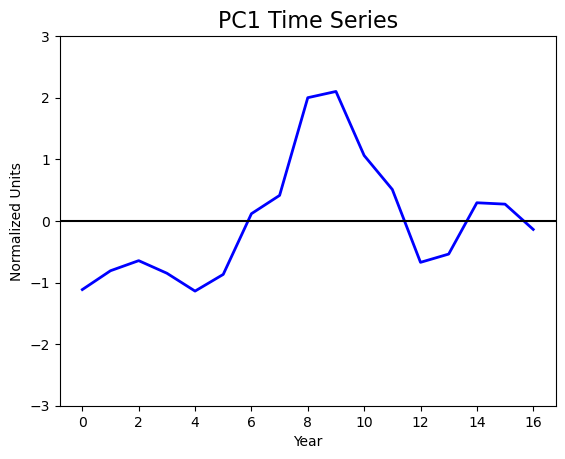

In [553]:
plt.figure()
plt.plot(pcs[:, 0], color='b', linewidth=2)
ax = plt.gca()
ax.axhline(0, color='k')
ax.set_ylim(-3, 3)
ax.set_xlabel('Year')
ax.set_ylabel('Normalized Units')
ax.set_title('PC1 Time Series', fontsize=16)

plt.show()

In [275]:
cube_df = cube.to_dataframe()
#cube_df.reset_index(inplace=True)
cube_df

t  spatial_ref
frp   y     x                                   
0.49  41.00 -123.1250  1.600646e+18            0
            -122.8125  1.600646e+18            0
      41.25 -123.1250  1.600646e+18            0
            -122.8125  1.600646e+18            0
      41.50 -123.1250  1.600646e+18            0
...                             ...          ...
34.49 41.00 -122.8125  1.600301e+18            0
      41.25 -123.1250  1.600301e+18            0
            -122.8125  1.600301e+18            0
      41.50 -123.1250  1.600301e+18            0
            -122.8125  1.600301e+18            0

[780 rows x 2 columns]

In [324]:
combo = cube.combine_first(tmp)

ValueError: cannot re-index or align objects with conflicting indexes found for the following dimensions: 'lon' (2 conflicting indexes), 'lat' (2 conflicting indexes), 'time' (2 conflicting indexes)
Conflicting indexes may occur when
- they relate to different sets of coordinate and/or dimension names
- they don't have the same type
- they may be used to reindex data along common dimensions